In [1]:
import torch 
import gym
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
import numba
import sys
import time

N_a = 3                             # number of possible actions (actions are -1, 0, and 1)
sigma = 0.1                         # noise
dim = 2                             # dimensionality of the space (v: R^d --> R)
pCNL = False
obs_min = np.array([-1.2,-0.07])
obs_max = np.array([ 0.6, 0.07])

In [2]:
"""

FUNCTIONS - VALUE FUNCTION AND POLICIES

"""

''' Progress bar to know how much longer one has to wait '''
def progressBar(value, endvalue, bar_length=40):
    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))
    sys.stdout.write("\rPercent: [{0}] {1}%".format(arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush() 
    
''' u(xi,x), which evaluates the function u with coefficients xi at x=(pos,speed) --- new, complicated, but fast version '''
@numba.njit()
def u(xi,x):
    u_sum = 0
    for j in range(dim):
        
        ''' 1D terms '''
        j_eval = np.pi*(x[j]-obs_min[j])/(obs_max[j]-obs_min[j])
        for i in range(1,N_trunc):
            c_j = 2/(obs_max[j]-obs_min[j])
            u_sum += c_j*xi[2*i-2,j,0]*np.cos(i*j_eval)
            u_sum += c_j*xi[2*i-1,j,0]*np.sin(i*j_eval)
            
        ''' 2D terms '''   
        for k in range(dim):
            if k>j:
                j_eval = np.pi*(x[j]-obs_min[j])/(obs_max[j]-obs_min[j])
                k_eval = np.pi*(x[k]-obs_min[k])/(obs_max[k]-obs_min[k])
                for i_1 in range(1,N_trunc):
                    for i_2 in range(1,N_trunc):
                        c_jk = 4/(obs_max[j]-obs_min[j])/(obs_max[k]-obs_min[k])
                        u_sum += c_jk*xi[4*(i_1+N_trunc*i_2)-4,j,k]*np.cos(i_1*j_eval)*np.cos(i_2*k_eval)
                        u_sum += c_jk*xi[4*(i_1+N_trunc*i_2)-3,j,k]*np.cos(i_1*j_eval)*np.sin(i_2*k_eval)
                        u_sum += c_jk*xi[4*(i_1+N_trunc*i_2)-2,j,k]*np.sin(i_1*j_eval)*np.cos(i_2*k_eval)
                        u_sum += c_jk*xi[4*(i_1+N_trunc*i_2)-1,j,k]*np.sin(i_1*j_eval)*np.sin(i_2*k_eval)
    return u_sum
''' Policy from "Reinforcement Learning: Theory and {Python} Implementation" '''
def policy(position,velocity):
        lb = min(-0.09 * (position + 0.25) ** 2 + 0.03,
                0.3 * (position + 0.9) ** 4 - 0.008)
        ub = -0.07 * (position + 0.38) ** 2 + 0.07
        if lb < velocity < ub:
            action = 2 # push right
        else:
            action = 0 # push left
        return action

# MAIN PROGRAMME

In [3]:
"""

MAIN PROGRAMME - SHOW LEARNED BEHAVIOUR

"""   
   
env = gym.make('MountainCar-v0')
env = env.unwrapped

failures = np.zeros(3)
steps = [[],[],[]]


'''
Behaviour following the optimal policy
'''
for _ in range(100):
    pos_curr,speed_curr = env.reset()
    for k in range(200):
        pos_curr,speed_curr = env.step(policy(pos_curr,speed_curr))[0] 
        
        if pos_curr>0.5:
            steps[0].append(k)
            break
    if k==199:
        failures[0]+=1
print('Optimal policy done.')
s = 1

Optimal policy done.


In [4]:
""" load samples - pCN """

method = 'pCN'
N_data = 50
N_trunc = 7

xi = []
for it in range(1000):
    xi.append(np.load('np_saved/MC/samples_policy_learning/KL_'+str(N_trunc)+'_'+method+'_NData'+str(N_data)+'_sampleNo'+str(it)+'.npy'))
      

""" run tests - pCN """

v = np.zeros(N_a)
v_with_noise = np.zeros(N_a)

errors = 0
corrects = 0

print('Test started: ' + str(time.ctime()))
for _ in range(100):
    pos_curr,speed_curr = env.reset()

    for k in range(200):
        progressBar(k+1,200)

        ''' See where different actions would take us, evaluate mean of value function samples there '''
        v = np.zeros(N_a)
        for it in range(1000): # Iterate through different neural networks
            for i in range(N_a):
                x = env.step(i)[0]
                v[i] += u(xi[it],x)
                env.state = [pos_curr,speed_curr]
        v = v/1000 # to get mean of value function evaluations

        ''' Pick action which maximises the mean value function (plus noise) at the new location '''
        v_with_noise = v+np.random.normal(np.zeros(N_a),sigma*np.ones(N_a)) 
        a_argmax_with_noise = np.argmax(v_with_noise)

        ''' Check whether learned action is the same as true action would be '''
        if a_argmax_with_noise != policy(pos_curr,speed_curr):
            errors+=1
        else:
            corrects+=1

        pos_curr,speed_curr = env.step(a_argmax_with_noise)[0]

        if pos_curr>0.5:
            steps[s].append(k)
            break
    if k==199:
        failures[s]+=1
    progressBar(200,200)
    print('\n')

print('Errorrate = ',(errors/(errors+corrects))) # Only makes sense if following learned policy
s+=1
print('pCN done, '+ str(time.ctime()))
        
    
    
    
""" load samples - pCNL """

method = 'pCNL'
N_data = 50
N_trunc = 7

xi = []
for it in range(1000):
    xi.append(np.load('np_saved/MC/samples_policy_learning/KL_'+str(N_trunc)+'_'+method+'_NData'+str(N_data)+'_sampleNo'+str(it)+'.npy'))
      

""" run tests - pCNL """

v = np.zeros(N_a)
v_with_noise = np.zeros(N_a)

errors = 0
corrects = 0

print('\n\nTest started: ' + str(time.ctime()))
for _ in range(100):
    pos_curr,speed_curr = env.reset()

    for k in range(200):
        progressBar(k+1,200)

        ''' See where different actions would take us, evaluate mean of value function samples there '''
        v = np.zeros(N_a)
        for it in range(1000): # Iterate through different neural networks
            for i in range(N_a):
                x = env.step(i)[0]
                v[i] += u(xi[it],x)
                env.state = [pos_curr,speed_curr]
        v = v/1000 # to get mean of value function evaluations

        ''' Pick action which maximises the mean value function (plus noise) at the new location '''
        v_with_noise = v+np.random.normal(np.zeros(N_a),sigma*np.ones(N_a)) 
        a_argmax_with_noise = np.argmax(v_with_noise)

        ''' Check whether learned action is the same as true action would be '''
        if a_argmax_with_noise != policy(pos_curr,speed_curr):
            errors+=1
        else:
            corrects+=1

        pos_curr,speed_curr = env.step(a_argmax_with_noise)[0]

        if pos_curr>0.5:
            steps[s].append(k)
            break
    if k==199:
        failures[s]+=1
    progressBar(200,200)
    print('\n')

print('Errorrate = ',(errors/(errors+corrects))) # Only makes sense if following learned policy
s+=1
print('pCNL done, '+ str(time.ctime()))
        
    
    
    
    
    
    
env.close()

Test started: Sun Jul 19 09:57:29 2020
Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [-----------------------

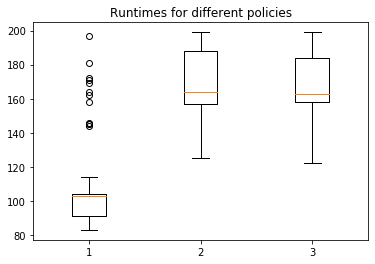

[ 0. 34. 24.]


In [5]:
fig1, ax1 = plt.subplots()
ax1.set_title('Runtimes for different policies')
ax1.boxplot(steps)
plt.show()

print(failures)

np.save('KL_steps.npy',np.array(steps))
np.save('KL_failures.npy',failures)